In [1]:
import scipy.io
import RLS
import numpy as np
import pandas as pd
import Data as df
import matplotlib.pylab as plt
import math
import pandas as pd
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27

f = scipy.io.loadmat('RLS_DATA.mat')
delay = 300
vars = f.keys()

data_size = f.get("RX_I").size

RX_Q_data = f.get("RX_Q")
RX_I_data = f.get("RX_I")
TX_Q_data = f.get("TX_Q")
TX_I_data = f.get("TX_I")

18 unique words found


In [2]:
def generate_input(data,mem_len,test_size,init=0,finish=data_size):

    every_input     = np.zeros((test_size,mem_len))
    avilable_input  = np.zeros(mem_len)

    if test_size+init < len(data):
        print("Test size + init --- data len",test_size+init , len(data)) ##Test Size or init should be smaller
        
    data            = data[init:test_size+init]
    
    for k in range (mem_len):
        data = np.insert(data,0,0)
    
    for j in range (test_size):
        for i in range (mem_len):
            avilable_input[i] = data[j+i]
        every_input[j] = avilable_input
    
    return every_input 

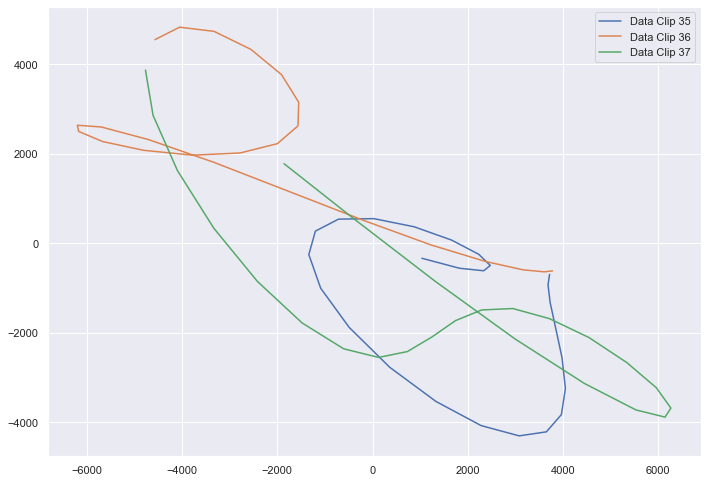

In [3]:
est_per = 25
num_test = 3
inital_clip = 35
end_clip = inital_clip+num_test

line_refernce = np.linspace(0,est_per,est_per)

for i in range (inital_clip,end_clip):
    plt.plot(TX_Q_data[i*est_per:(i+1)*(est_per)],RX_Q_data[delay+i*est_per:(i+1)*(est_per)+delay],    label='Data Clip {}'.format(i))  

#plt.step(line_refernce,np.squeeze(every_pure_input).T[0:test_size][0],label='Pure_Input')      
#plt.step(line_refernce, every_input[0:test_size],label='Curropted Signal') 
#plt.step(line_refernce,every_input[0:test_size],label='Input Signals After The Channels')       
plt.legend()

In [4]:
# Data Preparation
len_data =len(RX_Q_data)
assert(len(RX_Q_data) == len(TX_Q_data))
ratio = 1
#ratio = 0.05
training_data   = int(len_data*ratio)
test_data       = len_data- training_data

# Generate Inpute Sequance
mem = 6
every_input     = generate_input(TX_Q_data[0:training_data],mem,training_data)
RX_Q_to_train   = RX_Q_data[delay:training_data+delay]
RX_Q_to_train_2 = -RX_Q_to_train
RX_Q_to_train = np.concatenate((RX_Q_to_train,RX_Q_to_train_2),axis=1)

In [5]:
#RNN Class

# It is possible to use this class when there the inputs are one dimensional

class RNN:
    def __init__(self,input_len,output_len,mem,hidden_size =15):
        self.Wya = np.random.randn(output_len,hidden_size)/10
        self.Wax = np.random.randn(hidden_size,input_len)/10
        self.Waa = np.random.randn(hidden_size,hidden_size)/10

        self.by = np.zeros((output_len,1))
        self.ba = np.zeros((hidden_size,1))

        self.hidden_size    = hidden_size
        self.output_len     = output_len
        self.input_len      = input_len

        self.mem = mem
        self.overshoot = 0

    def forward_prop(self,measurement):
       
        self.last_as = [0]*len(measurement)
        # Number of a parameter depends on number of measurement
        # Measurment intake depends on memory parameter
    
        a =  np.zeros((self.hidden_size, 1))
        self.last_as = { 0: a }
        self.last_measurement = measurement


        for i ,x in enumerate(measurement):
            # x value of the input
            # i sequance of the input

            k = self.Wax*x
            j = np.matmul(self.Waa,a)
            assert(np.shape(k) == (self.hidden_size,1))
            a = np.tanh(k + j + self.ba)

            # Store the a for backprop
            self.last_as[i+1] = a 

        
        #Store the inputs for backprop

        y = np.matmul(self.Wya,a) + self.by
        assert(np.shape(y) == (self.output_len,1))
        
        return y, a


    def back_prop(self,dL_dy,learning_rate = 0.001):
        dWya =  np.zeros(self.Wya.shape)
        dWax =  np.zeros(self.Wax.shape)
        dWaa =  np.zeros(self.Waa.shape)
        dby  =  np.zeros(self.by.shape)
        dba  =  np.zeros(self.ba.shape)

        n = len(self.last_measurement)
        dWya = np.matmul(dL_dy,self.last_as[n].T)
        dby = dL_dy
        
        temp = 1
        dh = np.matmul(self.Wya.T,dL_dy)
        
        for i in reversed(range(n)):
            temp =((1 - self.last_as[i + 1] ** 2))
            self.last_measurement = np.reshape((self.last_measurement),(self.mem,1))
            temp = temp*dh
            dWaa += temp * self.last_as[i].T
            dWax +=  temp*self.last_measurement[i]       
            dba  += temp
            dh = np.matmul(self.Waa.T,temp)
        
        #   Exploding and Vanishing Gradient problem 
        #   Work around the solution
        #for d in [dWax, dWaa, dWya, dba, dby]:
        #    np.clip(d, -1, 1, out=d)

        self.Wax = self.Wax  - learning_rate*dWax
        self.Waa = self.Waa  - learning_rate*dWaa
        self.Wya = self.Wya  - learning_rate*dWya

        self.by =  self.by -learning_rate*dby
        self.ba =  self.ba -learning_rate*dba 

In [6]:
def linear(xs):
  # Applies the Softmax Function to the input array.
  return xs

In [7]:
# Initialize our RNN!

rnn = RNN(1, 2,mem)
loss_data = []

def processData(data,refernce,backprop=True ):
  '''
  Returns the RNN's loss and accuracy for the given data.
  - data is a dictionary mapping text to True or False.
  - backprop determines if the backward phase should be run.
  '''
  items = data
  loss = 0
  num_correct = 0

  for x in range (len(items)):
    inputs = items[x]  
    target = refernce[x]
    #print("Input >>>>",inputs,"Targets >>>>", target)
    # Forward
    out, _ = rnn.forward_prop(inputs)

    probs = linear(out)
    target = np.reshape(target,(2,1))
    #print("Probs >>>>",probs,np.shape(probs))
    # Calculate loss / accuracy
    loss += (target-probs[0])**2

    #If Classification
    #num_correct += int(np.argmax(probs) == target)

    if backprop:
        # Build dL/dy
        d_L_d_y = -2*(target-probs)

        # Backward
        rnn.back_prop(d_L_d_y)

  return loss / len(data),   num_correct / len(data)


# Training loop
for epoch in range(1000):

  train_loss, train_acc = processData(data = every_input, refernce=RX_Q_to_train )

  if epoch % 100 == 99:
    print('--- Epoch %d' % (epoch + 1))
    print("Train:\tLoss" ,train_loss[0],"    | Accuracy:   ", train_acc)
    loss_data.append(train_loss[0])
    test_loss, test_acc = processData(data = every_input, backprop=True,refernce=RX_Q_to_train)
  
line_refernce = np.linspace(0,2500,len(loss_data))
plt.plot(line_refernce,loss_data)  

IndexError: index 16084 is out of bounds for axis 0 with size 16084

In [8]:
i = 50
est_per = 100
every_input = generate_input(TX_Q_data,mem,100,i)

RX_Q_to_test = RX_Q_data[delay+i*est_per:(i+1)*(est_per)+delay]
RX_Q_to_test_2 = -RX_Q_to_test
RX_Q_to_test = np.concatenate((RX_Q_to_test,RX_Q_to_test_2),axis=1)
RX_Q_to_test = np.reshape(RX_Q_to_test.T[1],(len(RX_Q_to_test.T[1]),1))

Test size + init --- data len 150 16384


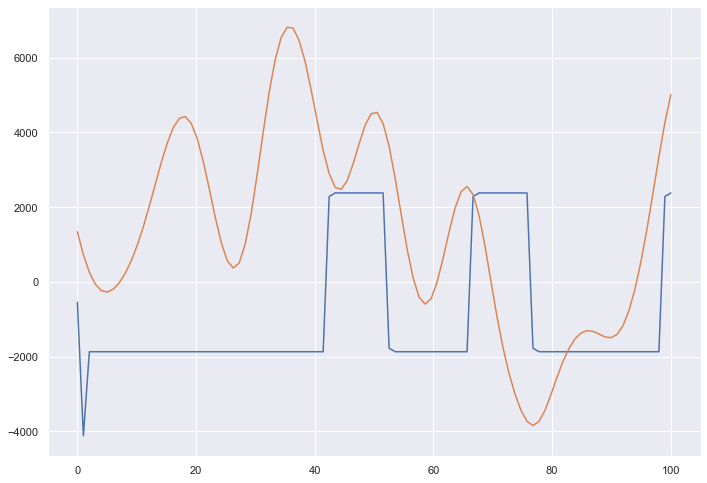

In [9]:
store_results = []
for i in range(len(every_input)):
    out, _ = rnn.forward_prop(every_input[i])
    store_results.append(out[1][:])

line_refernce = np.linspace(0,len(store_results),len(store_results))
plt.plot(line_refernce,store_results)  
plt.plot(line_refernce,RX_Q_to_test)  


In [10]:
i = 70
est_per = 200
every_input = generate_input(TX_Q_data,mem,est_per,i)

RX_Q_to_test = RX_Q_data[delay+i*est_per:(i+1)*(est_per)+delay]
RX_Q_to_test_2 = -RX_Q_to_test
RX_Q_to_test = np.concatenate((RX_Q_to_test,RX_Q_to_test_2),axis=1)
RX_Q_to_test = np.reshape(RX_Q_to_test.T[1],(len(RX_Q_to_test.T[1]),1))

Test size + init --- data len 270 16384


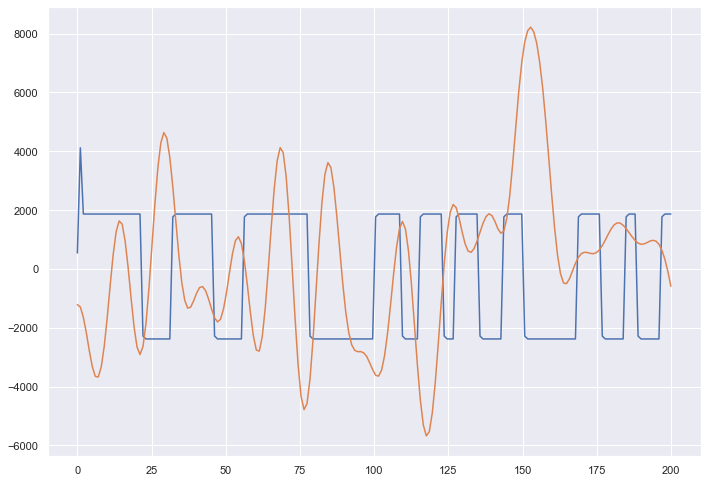

In [11]:
store_results = []
for i in range(len(every_input)):
    out, _ = rnn.forward_prop(every_input[i])
    store_results.append(out[0][:])

line_refernce = np.linspace(0,len(store_results),len(store_results))
plt.plot(line_refernce,store_results)  
plt.plot(line_refernce,RX_Q_to_test)  

In [12]:
i = 20
est_per = 150
every_input = generate_input(TX_Q_data,mem,est_per,i)

RX_Q_to_test = RX_Q_data[delay+i*est_per:(i+1)*(est_per)+delay]
RX_Q_to_test_2 = -RX_Q_to_test
RX_Q_to_test = np.concatenate((RX_Q_to_test,RX_Q_to_test_2),axis=1)
RX_Q_to_test = np.reshape(RX_Q_to_test.T[1],(len(RX_Q_to_test.T[1]),1))

Test size + init --- data len 170 16384


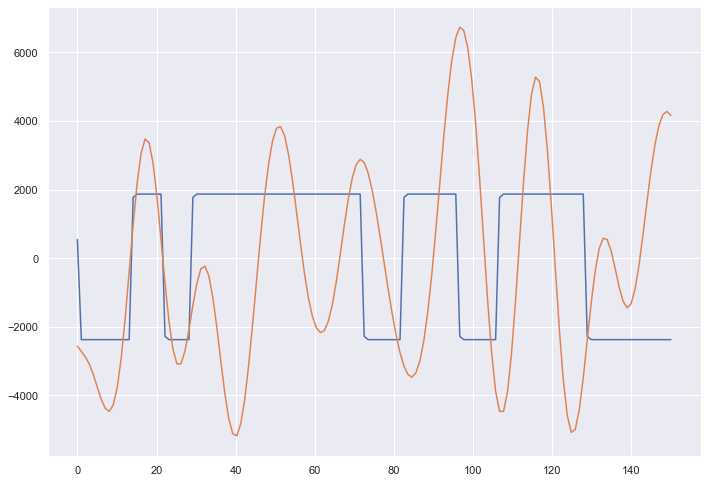

In [14]:
store_results = []
for i in range(len(every_input)):
    out, _ = rnn.forward_prop(every_input[i])
    store_results.append(out[0][:])

line_refernce = np.linspace(0,len(store_results),len(store_results))
plt.plot(line_refernce,store_results)  
plt.plot(line_refernce,RX_Q_to_test)  

In [ ]:
## The Probelm Vanishing Gradiant ?? 
#  Checking now


In [19]:
#RNN Class

# It is possible to use this class when there the inputs are one dimensional

class RNN:
    def __init__(self,input_len,output_len,mem,hidden_size =10):
        self.Wya = np.random.randn(output_len,hidden_size)*100
        self.Wax = np.random.randn(hidden_size,input_len)*100
        self.Waa = np.random.randn(hidden_size,hidden_size)/100

        self.by = np.zeros((output_len,1))
        self.ba = np.zeros((hidden_size,1))

        self.hidden_size    = hidden_size
        self.output_len     = output_len
        self.input_len      = input_len

        self.mem = mem
        self.overshoot = 0

    def forward_prop(self,measurement):
       
        self.last_as = [0]*len(measurement)
        # Number of a parameter depends on number of measurement
        # Measurment intake depends on memory parameter
    
        a =  np.zeros((self.hidden_size, 1))
        self.last_as = { 0: a }
        self.last_measurement = measurement


        for i ,x in enumerate(measurement):
            # x value of the input
            # i sequance of the input

            k = self.Wax*x
            j = np.matmul(self.Waa,a)
            assert(np.shape(k) == (self.hidden_size,1))
            a = np.tanh(k + j + self.ba)

            # Store the a for backprop
            self.last_as[i+1] = a 

        
        #Store the inputs for backprop

        y = np.matmul(self.Wya,a) + self.by
        assert(np.shape(y) == (self.output_len,1))
        
        return y, a


    def back_prop(self,dL_dy,learning_rate = 0.0001):
        dWya =  np.zeros(self.Wya.shape)
        dWax =  np.zeros(self.Wax.shape)
        dWaa =  np.zeros(self.Waa.shape)
        dby  =  np.zeros(self.by.shape)
        dba  =  np.zeros(self.ba.shape)

        n = len(self.last_measurement)
        dWya = np.matmul(dL_dy,self.last_as[n].T)
        dby = dL_dy
        
        temp = 1
        dh = np.matmul(self.Wya.T,dL_dy)
        
        for i in reversed(range(n)):
            temp =((1 - self.last_as[i + 1] ** 2))
            self.last_measurement = np.reshape((self.last_measurement),(self.mem,1))
            temp = temp*dh
            dWaa += temp * self.last_as[i].T
            dWax +=  temp*self.last_measurement[i]       
            dba  += temp
            dh = np.matmul(self.Waa.T,temp)
        
        #   Exploding and Vanishing Gradient problem 
        #   Work around the solution
        for d in [dWax, dWaa, dWya, dba, dby]:
            np.clip(d, -10, 10, out=d)

        self.Wax = self.Wax  - learning_rate*dWax
        self.Waa = self.Waa  - learning_rate*dWaa
        self.Wya = self.Wya  - learning_rate*dWya

        self.by =  self.by -learning_rate*dby
        self.ba =  self.ba -learning_rate*dba 

--- Epoch 100
Train:	Loss [11594449.19108617]     | Accuracy:    0.0 0.01
--- Epoch 200
Train:	Loss [11594449.30385852]     | Accuracy:    0.0 0.005
--- Epoch 300
Train:	Loss [11594449.40919962]     | Accuracy:    0.0 0.003333333333333333
--- Epoch 400
Train:	Loss [11594449.49576769]     | Accuracy:    0.0 0.0025
--- Epoch 500
Train:	Loss [11594449.56805662]     | Accuracy:    0.0 0.002
--- Epoch 600
Train:	Loss [11594449.62981956]     | Accuracy:    0.0 0.0016666666666666666
--- Epoch 700
Train:	Loss [11594449.68363191]     | Accuracy:    0.0 0.0014285714285714286
--- Epoch 800
Train:	Loss [11594449.73126497]     | Accuracy:    0.0 0.00125
--- Epoch 900
Train:	Loss [11594449.77397153]     | Accuracy:    0.0 0.0011111111111111111
--- Epoch 1000
Train:	Loss [11594449.81266452]     | Accuracy:    0.0 0.001


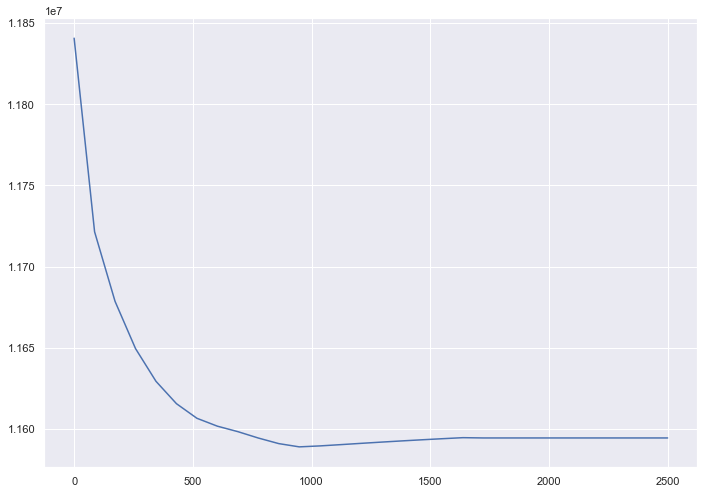

In [24]:
# Initialize our RNN!

#rnn = RNN(1, 2,mem)
#loss_data = []

def processData(data,refernce,epoch,backprop=True ):
  '''
  Returns the RNN's loss and accuracy for the given data.
  - data is a dictionary mapping text to True or False.
  - backprop determines if the backward phase should be run.
  '''
  items = data

  lr = 0.01**3
  lr = lr*epoch

  loss = 0
  num_correct = 0

  for x in range (len(items)):
    inputs = items[x]  
    target = refernce[x]
    # Forward
    out, _ = rnn.forward_prop(inputs)

    probs = linear(out)
    target = np.reshape(target,(2,1))
    # Calculate loss / accuracy
    loss += (target-probs[0])**2

    #If Classification
    #num_correct += int(np.argmax(probs) == target)

    if backprop:
        # Build dL/dy
        d_L_d_y = -2*(target-probs)

        # Backward

        rnn.back_prop(d_L_d_y,lr)

  return loss / len(data),   num_correct / len(data)


# Training loop
for epoch in range(1000):

  lr_k = (1/int((epoch / 100)+1))
  if lr_k == 0:
    lr_k = 1
  
  train_loss, train_acc = processData(data = every_input,epoch= lr_k ,refernce=RX_Q_to_train )

  if epoch % 100 == 99:
    print('--- Epoch %d' % (epoch + 1))
    print("Train:\tLoss" ,train_loss[0],"    | Accuracy:   ", train_acc,lr_k*0.01)
    loss_data.append(train_loss[0])
    test_loss, test_acc = processData(data = every_input,epoch= lr_k ,backprop=True,refernce=RX_Q_to_train)
  
line_refernce = np.linspace(0,2500,len(loss_data))
plt.plot(line_refernce,loss_data)  

Test size + init --- data len 210 16384


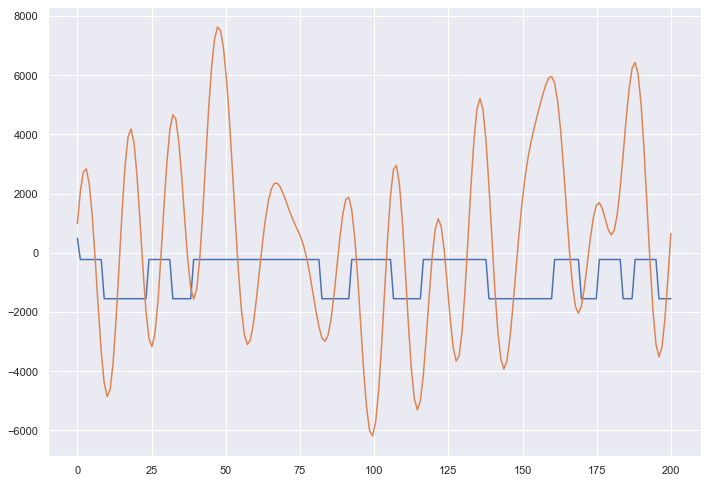

In [26]:
i = 10
est_per = 200
every_input = generate_input(TX_Q_data,mem,est_per,i)

RX_Q_to_test = RX_Q_data[delay+i*est_per:(i+1)*(est_per)+delay]
RX_Q_to_test_2 = -RX_Q_to_test
RX_Q_to_test = np.concatenate((RX_Q_to_test,RX_Q_to_test_2),axis=1)
RX_Q_to_test = np.reshape(RX_Q_to_test.T[1],(len(RX_Q_to_test.T[1]),1))

store_results = []
for i in range(len(every_input)):
    out, _ = rnn.forward_prop(every_input[i])
    store_results.append(out[1][:])

line_refernce = np.linspace(0,len(store_results),len(store_results))
plt.plot(line_refernce,store_results)  
plt.plot(line_refernce,RX_Q_to_test)  

In [ ]:
## Is the problem learning rate ??
# Chekcing Below

In [27]:
#RNN Class

# It is possible to use this class when there the inputs are one dimensional

class RNN:
    def __init__(self,input_len,output_len,mem,hidden_size =20):
        self.Wya = np.random.randn(output_len,hidden_size)/20
        self.Wax = np.random.randn(hidden_size,input_len)/20
        self.Waa = np.random.randn(hidden_size,hidden_size)/100

        self.by = np.zeros((output_len,1))
        self.ba = np.zeros((hidden_size,1))

        self.hidden_size    = hidden_size
        self.output_len     = output_len
        self.input_len      = input_len

        self.mem = mem
        self.overshoot = 0

    def forward_prop(self,measurement):
       
        self.last_as = [0]*len(measurement)
        # Number of a parameter depends on number of measurement
        # Measurment intake depends on memory parameter
    
        a =  np.zeros((self.hidden_size, 1))
        self.last_as = { 0: a }
        self.last_measurement = measurement


        for i ,x in enumerate(measurement):
            # x value of the input
            # i sequance of the input

            k = self.Wax*x
            j = np.matmul(self.Waa,a)
            assert(np.shape(k) == (self.hidden_size,1))
            a = np.tanh(k + j + self.ba)

            # Store the a for backprop
            self.last_as[i+1] = a 

        
        #Store the inputs for backprop

        y = np.matmul(self.Wya,a) + self.by
        assert(np.shape(y) == (self.output_len,1))
        
        return y, a


    def back_prop(self,dL_dy,learning_rate = 0.001,clip = True):
        dWya =  np.zeros(self.Wya.shape)
        dWax =  np.zeros(self.Wax.shape)
        dWaa =  np.zeros(self.Waa.shape)
        dby  =  np.zeros(self.by.shape)
        dba  =  np.zeros(self.ba.shape)

        n = len(self.last_measurement)
        dWya = np.matmul(dL_dy,self.last_as[n].T)
        dby = dL_dy
        
        temp = 1
        dh = np.matmul(self.Wya.T,dL_dy)
        
        for i in reversed(range(n)):
            temp =((1 - self.last_as[i + 1] ** 2))
            self.last_measurement = np.reshape((self.last_measurement),(self.mem,1))
            temp = temp*dh
            dWaa += temp * self.last_as[i].T
            dWax +=  temp*self.last_measurement[i]       
            dba  += temp
            dh = np.matmul(self.Waa.T,temp)
        
        #   Exploding and Vanishing Gradient problem 
        #   Work around the solution
        if clip :
            for d in [dWax, dWaa, dWya, dba, dby]:
                np.clip(d, -5, 5, out=d)

        self.Wax = self.Wax  - learning_rate*dWax
        self.Waa = self.Waa  - learning_rate*dWaa
        self.Wya = self.Wya  - learning_rate*dWya

        self.by =  self.by -learning_rate*dby
        self.ba =  self.ba -learning_rate*dba 

In [34]:
def adjust_data(every_input,every_reference,train_len,epoch,lr_k):
    
    if lr_k == 0:
        lr_k = 1
    else:
        lr_k = lr_k
        
    if epoch > 5:
        clip  = True
    else:
        clip  = False

    every_input     = every_input[train_len*epoch:train_len*(epoch+1)]
    every_reference = every_reference[train_len*epoch:train_len*(epoch+1)]
    
    return lr_k,clip,every_input,every_reference
    

--- Epoch 1
Train:	Loss 9190790.193623396     | Accuracy:    0.0 | Learning rate:  0.9 Clip ?? False
--- Epoch 101
Train:	Loss 16742402.269843882     | Accuracy:    0.0 | Learning rate:  0.45 Clip ?? False
--- Epoch 201
Train:	Loss 7932407.298518714     | Accuracy:    0.0 | Learning rate:  0.3 Clip ?? False
--- Epoch 301
Train:	Loss 7020500.365495449     | Accuracy:    0.0 | Learning rate:  0.225 Clip ?? False
--- Epoch 401
Train:	Loss 4762538.201302313     | Accuracy:    0.0 | Learning rate:  0.18000000000000002 Clip ?? False
--- Epoch 501
Train:	Loss 15824105.210238919     | Accuracy:    0.0 | Learning rate:  0.15 Clip ?? False
--- Epoch 601
Train:	Loss 7832354.3576516025     | Accuracy:    0.0 | Learning rate:  0.12857142857142856 Clip ?? True
--- Epoch 701
Train:	Loss 6453687.390075407     | Accuracy:    0.0 | Learning rate:  0.1125 Clip ?? True
--- Epoch 801
Train:	Loss 15407265.040003216     | Accuracy:    0.0 | Learning rate:  0.09999999999999999 Clip ?? True
--- Epoch 901
Train

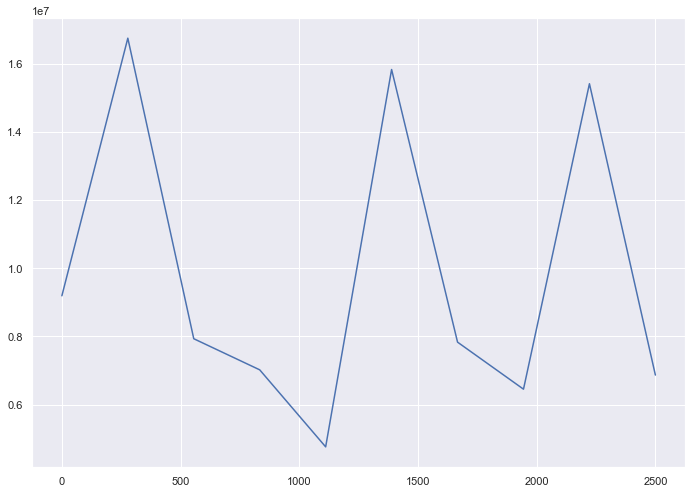

In [35]:
# Initialize our RNN!
# Data Preparation
len_data =len(RX_Q_data)
assert(len(RX_Q_data) == len(TX_Q_data))
ratio = 1
#ratio = 0.05
training_data   = int(len_data*ratio)
test_data       = len_data- training_data

# Generate Inpute Sequance
mem = 6
every_input     = generate_input(TX_Q_data[0:training_data],mem,training_data)
RX_Q_to_train   = RX_Q_data[delay:training_data+delay]
RX_Q_to_train_2 = -RX_Q_to_train
RX_Q_to_train = np.concatenate((RX_Q_to_train,RX_Q_to_train_2),axis=1)

rnn = RNN(1, 2,mem)
loss_data = []

def processData(data,refernce,epoch=1,backprop=True ,clip = True):
  '''
  Returns the RNN's loss and accuracy for the given data.
  - data is a dictionary mapping text to True or False.
  - backprop determines if the backward phase should be run.
  '''
  items = data
  loss = 0
  num_correct = 0
  lr = 0.5
  lr = lr*epoch

  for x in range (len(items)):
    inputs = items[x]
    target = refernce[x]

    #print(refernce,"<<- Reference || Target -->",target)
    #print("Input >>>>",inputs,"Targets >>>>", target)
    # Forward
    out, _ = rnn.forward_prop(inputs)

    probs = linear(out)
    target = np.reshape(target,(2,1))
    # Calculate loss / accuracy
    loss += np.sum((target-probs)**2)

    #If Classification
    #num_correct += int(np.argmax(probs) == target)

    if backprop:
        # Build dL/dy
        d_L_d_y = -2*(target-probs)

        # Backward
        rnn.back_prop(d_L_d_y,lr)

  return loss / len(data),   num_correct / len(data)

part_epoch = 0
clip       =True

# Training loop
for partial_epoch in range(1000):

  lr_k = (1/int((partial_epoch / 100)+1))

  if part_epoch != int(partial_epoch / 100):
    part_epoch = int(partial_epoch /100)
  
  lr_k ,clip,adjusted_input,adjusted_ref  = adjust_data(every_input = every_input[:-delay],every_reference= RX_Q_to_train,train_len = 100, epoch= part_epoch,lr_k=lr_k)

  train_loss, train_acc = processData(data = adjusted_input, backprop=True, refernce=adjusted_ref ,epoch=lr_k,clip= clip)

  if partial_epoch % 100 == 1:
    print('--- Epoch %d' % (partial_epoch))
    print("Train:\tLoss" ,train_loss, "    | Accuracy:   ", train_acc , "| Learning rate: ", lr_k*0.9 ,"Clip ??" ,clip)
    loss_data.append(train_loss)
  
line_refernce = np.linspace(0,2500,len(loss_data))
plt.plot(line_refernce,loss_data)  

In [54]:
i = 4
est_per = 150
every_input = generate_input(TX_Q_data,mem,est_per,i)

RX_Q_to_test = RX_Q_data[delay+i*est_per:(i+1)*(est_per)+delay]
RX_Q_to_test_2 = -RX_Q_to_test
RX_Q_to_test = np.concatenate((RX_Q_to_test,RX_Q_to_test_2),axis=1)
RX_Q_to_test = np.reshape(RX_Q_to_test.T[1],(len(RX_Q_to_test.T[1]),1))

Test size + init --- data len 154 16384


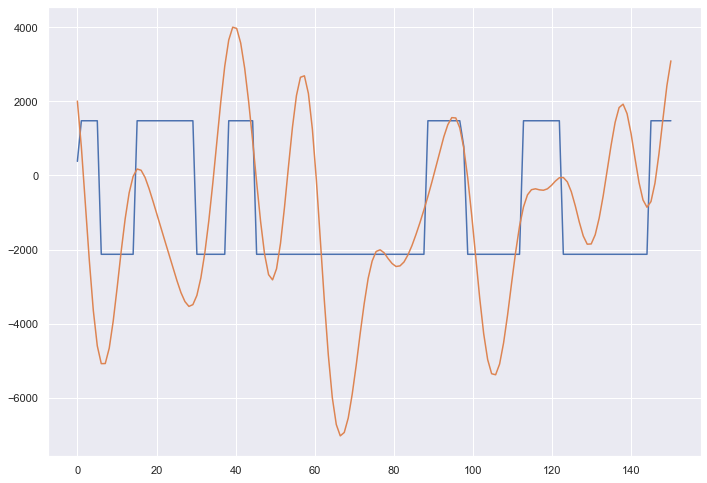

In [56]:
store_results = []
for i in range(len(every_input)):
    out, _ = rnn.forward_prop(every_input[i])
    store_results.append(out[1][:])

line_refernce = np.linspace(0,len(store_results),len(store_results))
plt.plot(line_refernce,store_results)  
plt.plot(line_refernce,RX_Q_to_test)  

In [ ]:

## Problem is vanishing gradient !!!